<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/RegressionModelv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Half-diagonal length of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top

# Generate points on the inward-curving rhombus
num_points_per_curve = 4
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)


In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 40  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta
        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu = beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape = p), beta))

        #prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), yls[i]))
        #mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + np.dot(Sigma_beta_inv, beta0))
        # Posterior log-probability
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_beta_post, cov=cov_beta_post, shape = p), beta))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), y_l).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


Cell execution time: 1179.27 seconds


[  0.48410715  -7.32506161 -59.6793697  ...   2.68349294   0.74437903
  -6.86734878]
[-2.11219238 -2.45083256 -3.95662229 ... -1.95343168 -2.16398115
 -2.17975577]
[ -1.62808522  -9.77589417 -63.63599199 ...   0.73006127  -1.41960213
  -9.04710455]


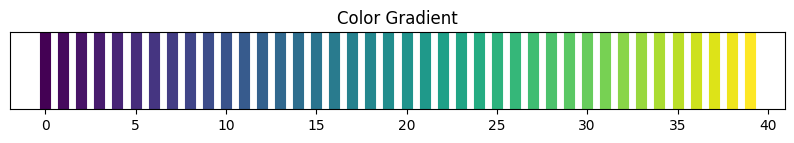

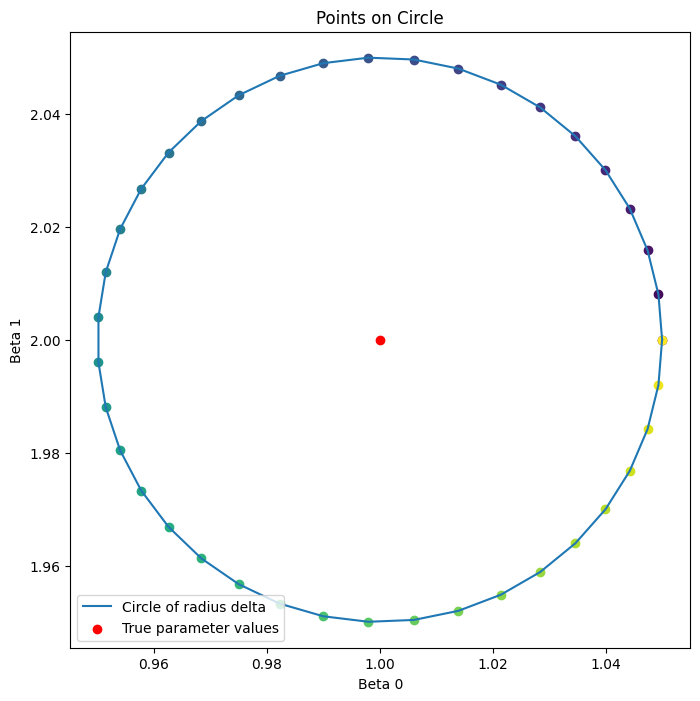

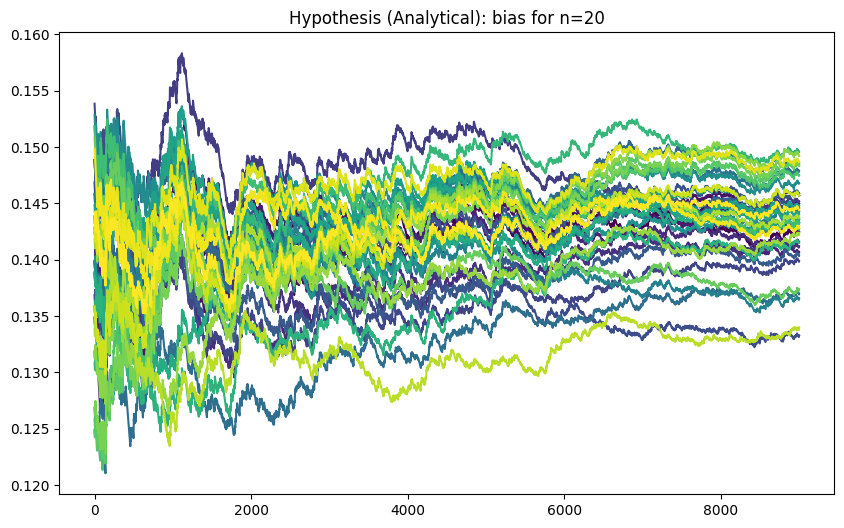

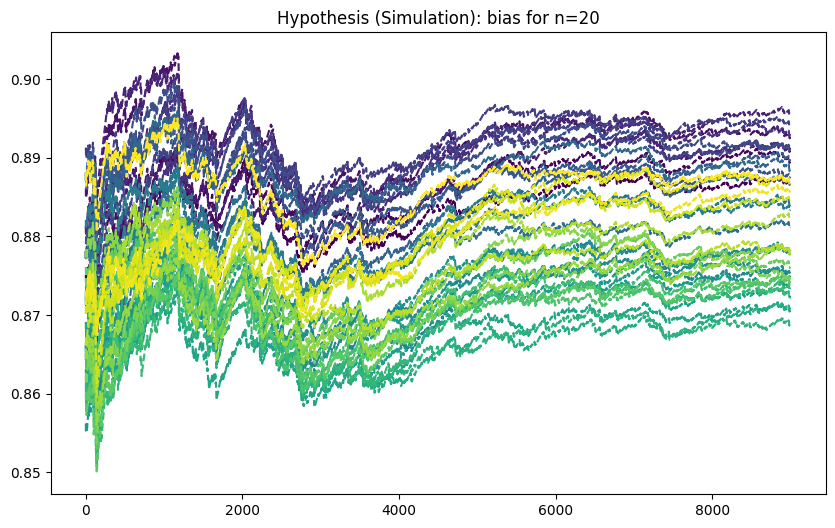

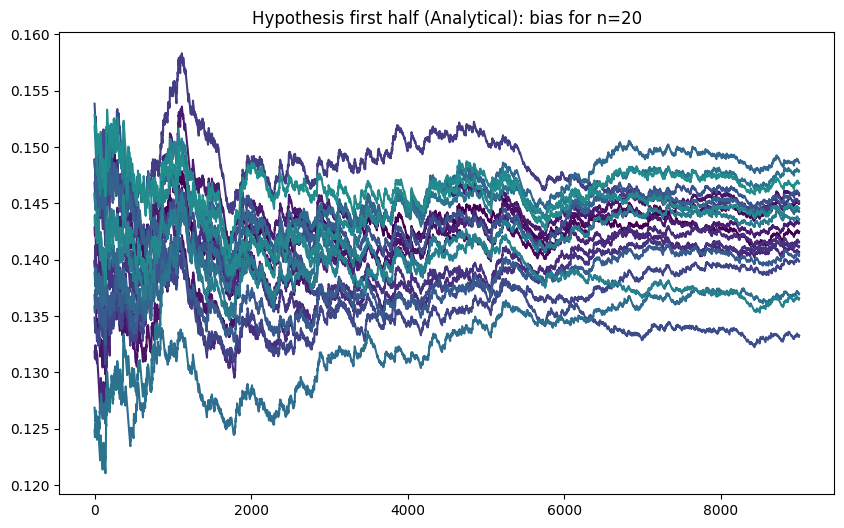

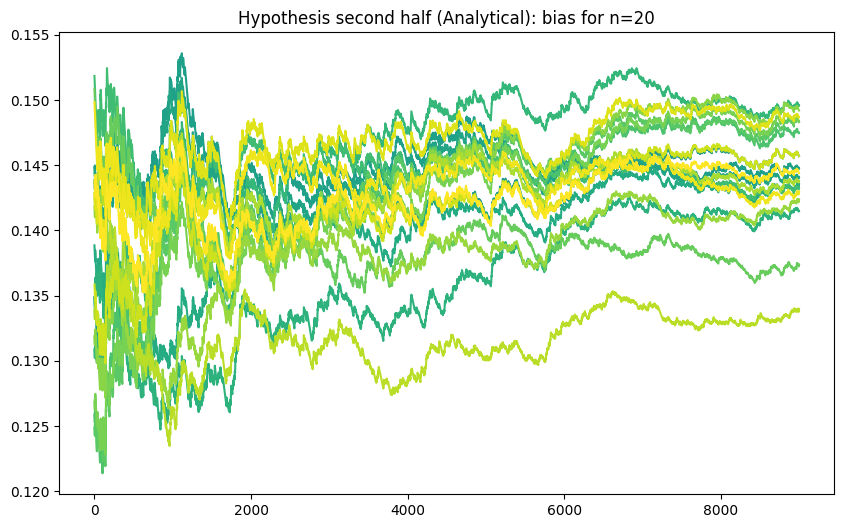

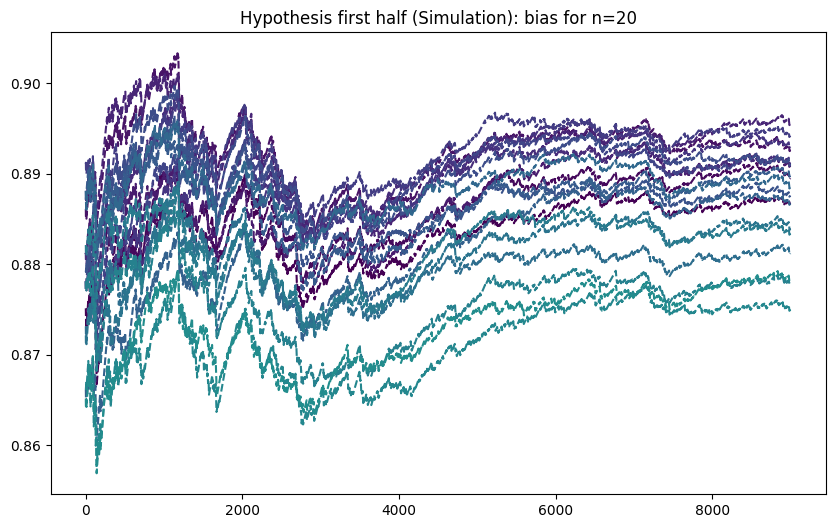

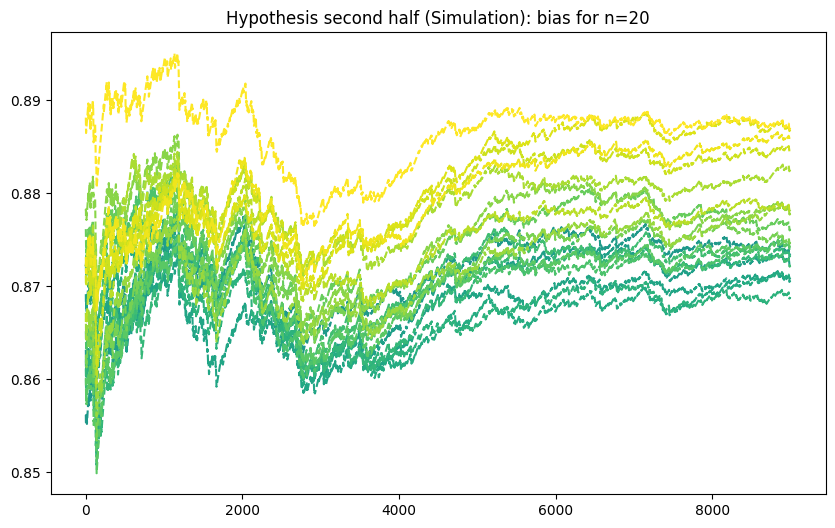

In [4]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [11]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 15  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (num_points, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (num_points, n)

start_time = time.time()
print(circle_points)
with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_beta = pm.MvNormal(f'prior_beta_{i}', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))

        # Prior predictive log-likelihood
        prior_mu = pm.math.dot(X, prior_beta)
        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=prior_mu, cov=np.eye(n), shape = n), mu))

        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + np.dot(Sigma_beta_inv, beta0))

        # Posterior distribution for beta at each point
        posterior_beta = pm.MvNormal(f'posterior_beta_{i}', mu=mean_beta_post, cov=cov_beta_post)

        # Posterior predictive log-likelihood
        posterior_mu = pm.math.dot(X, posterior_beta)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=posterior_mu, cov=np.eye(n), shape = n), mu))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")




[[1.05       2.        ]
 [1.04504844 2.02169419]
 [1.03117449 2.03909157]
 [1.01112605 2.0487464 ]
 [0.98887395 2.0487464 ]
 [0.96882551 2.03909157]
 [0.95495156 2.02169419]
 [0.95       2.        ]
 [0.95495156 1.97830581]
 [0.96882551 1.96090843]
 [0.98887395 1.9512536 ]
 [1.01112605 1.9512536 ]
 [1.03117449 1.96090843]
 [1.04504844 1.97830581]
 [1.05       2.        ]]


Cell execution time: 1784.83 seconds


[ 7.99763896 28.73695404 12.29654432 ...  7.37042529 20.94317971
  8.955745  ]
[-28.09708199 -51.04059677 -31.36210115 ... -37.58200685 -44.03893118
 -60.72081614]
[-20.09944303 -22.30364273 -19.06555683 ... -30.21158156 -23.09575147
 -51.76507115]


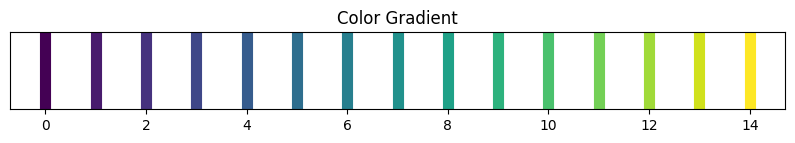

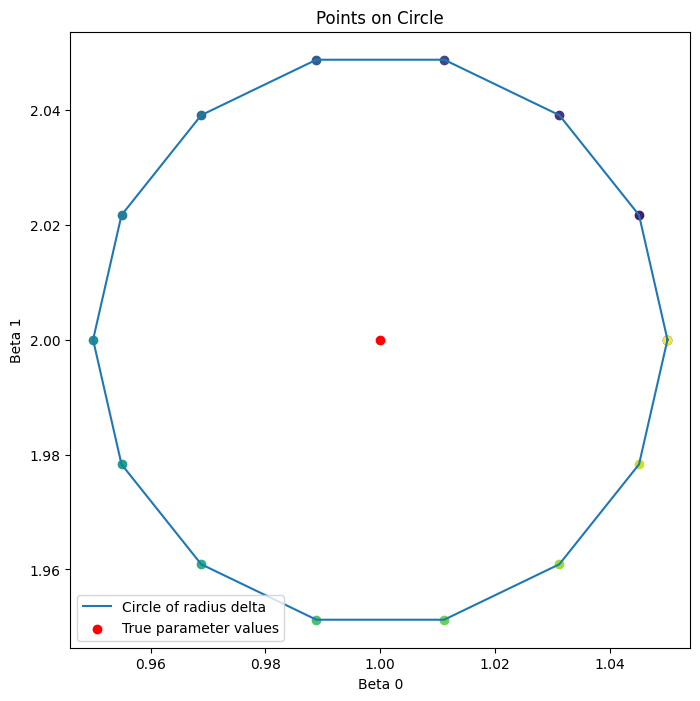

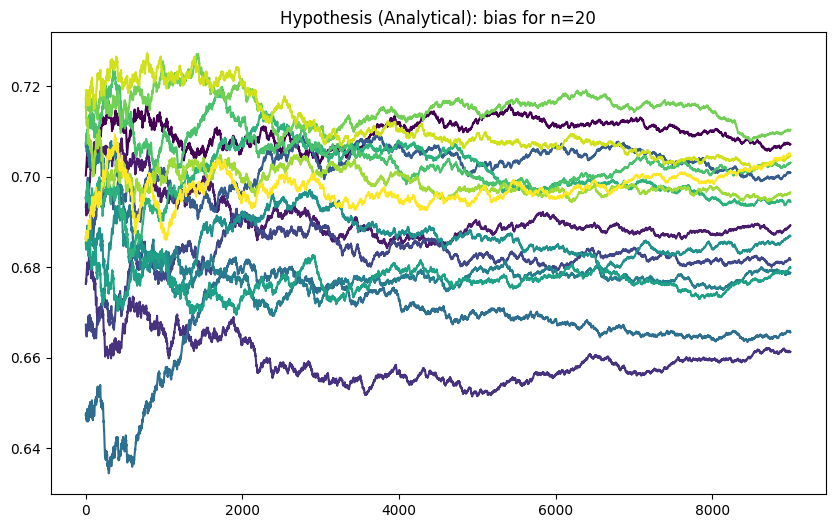

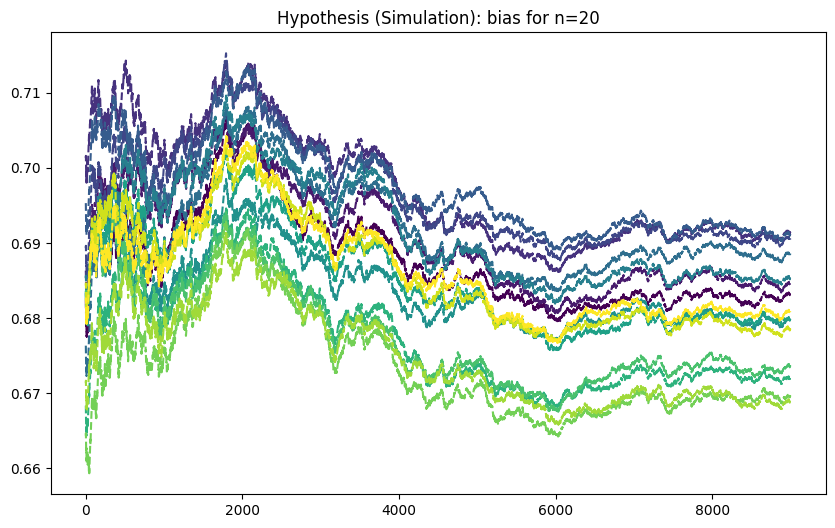

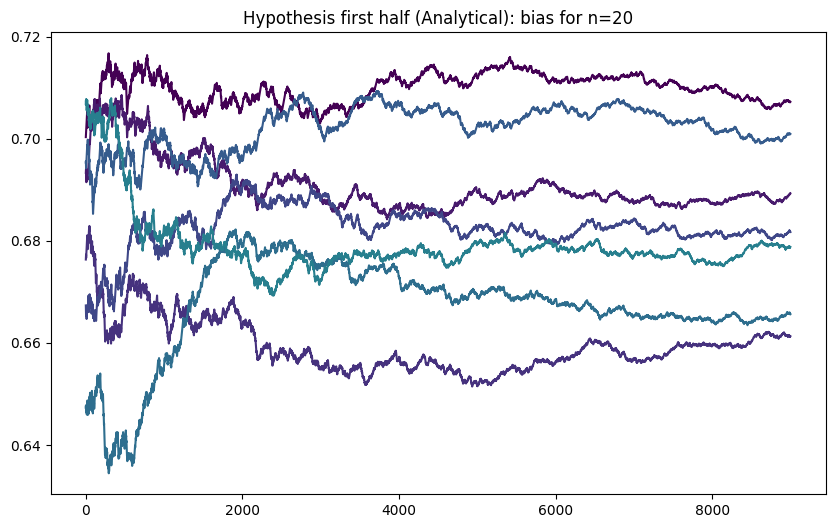

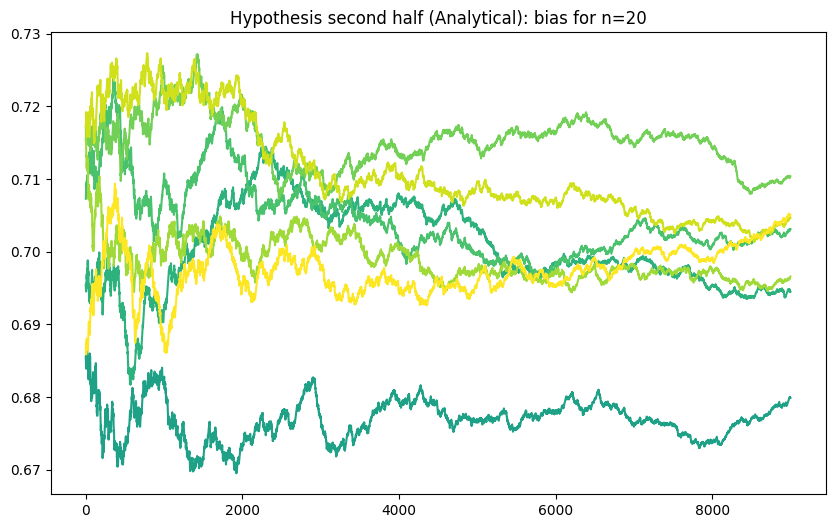

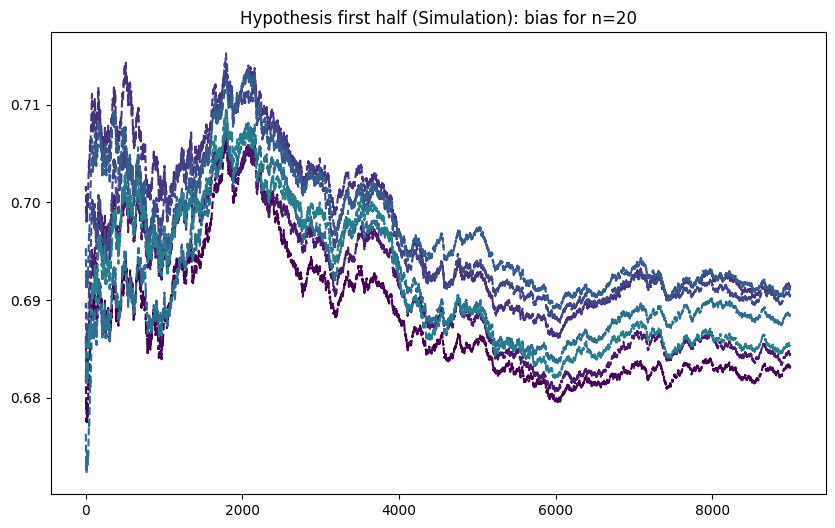

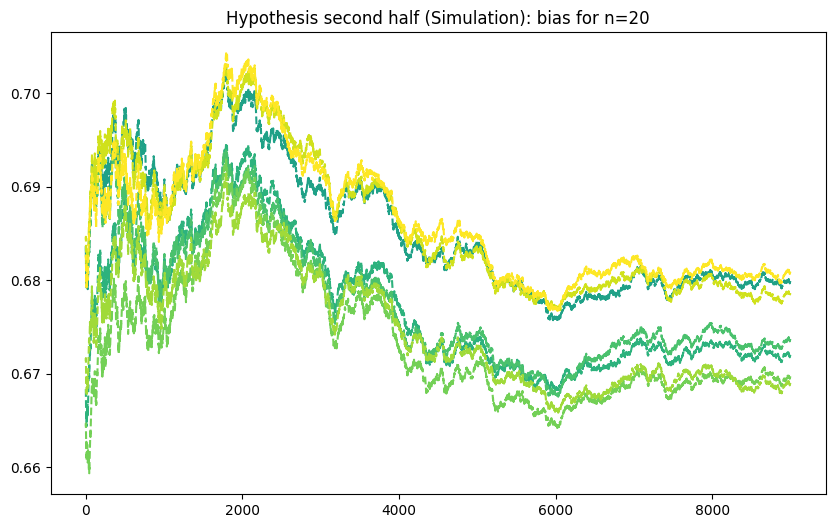

In [12]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Rough work

In [13]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 15  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (num_points, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (num_points, n)

start_time = time.time()
print(circle_points)
with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_beta = pm.MvNormal(f'prior_beta_{i}', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))

        # Prior predictive log-likelihood
        prior_mu = pm.math.dot(X, prior_beta)
        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=prior_mu, cov=np.eye(n), shape = n), mu))

        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + np.dot(Sigma_beta_inv, beta0))

        # Posterior distribution for beta at each point
        posterior_beta = pm.MvNormal(f'posterior_beta_{i}', mu=mean_beta_post, cov=cov_beta_post)

        # Posterior predictive log-likelihood
        posterior_mu = pm.math.dot(X, posterior_beta)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=posterior_mu, cov=np.eye(n), shape = n), mu))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yls[i]).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


[[1.05       2.        ]
 [1.04504844 2.02169419]
 [1.03117449 2.03909157]
 [1.01112605 2.0487464 ]
 [0.98887395 2.0487464 ]
 [0.96882551 2.03909157]
 [0.95495156 2.02169419]
 [0.95       2.        ]
 [0.95495156 1.97830581]
 [0.96882551 1.96090843]
 [0.98887395 1.9512536 ]
 [1.01112605 1.9512536 ]
 [1.03117449 1.96090843]
 [1.04504844 1.97830581]
 [1.05       2.        ]]


Cell execution time: 1799.64 seconds


[  7.75801087  -6.43573594   2.39888526 ... 160.12170887  27.9034765
   9.43397588]
[ -41.43435088  -35.35651171  -37.52886648 ... -191.49797994  -56.03684759
  -33.10915236]
[-33.67634001 -41.79224765 -35.12998122 ... -31.37627107 -28.13337109
 -23.67517649]


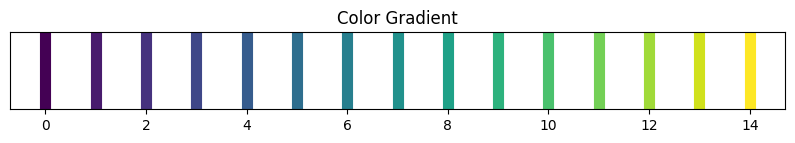

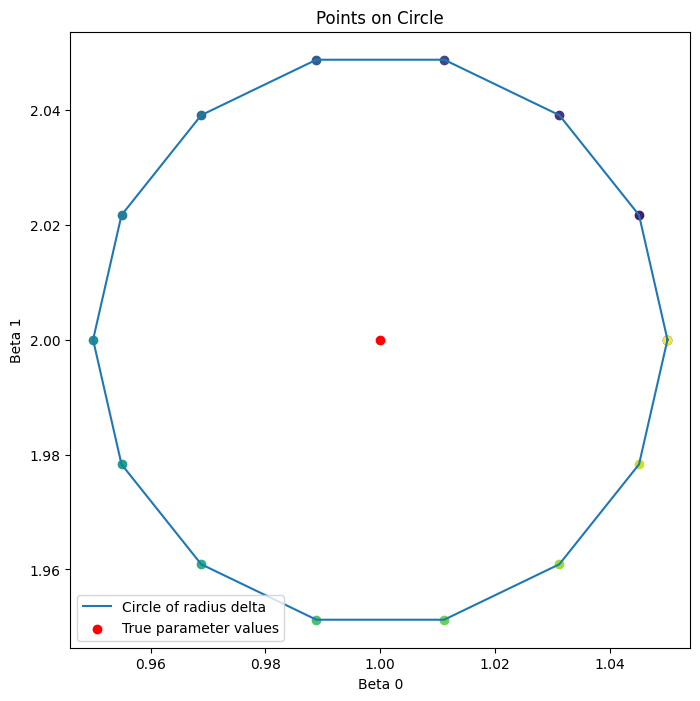

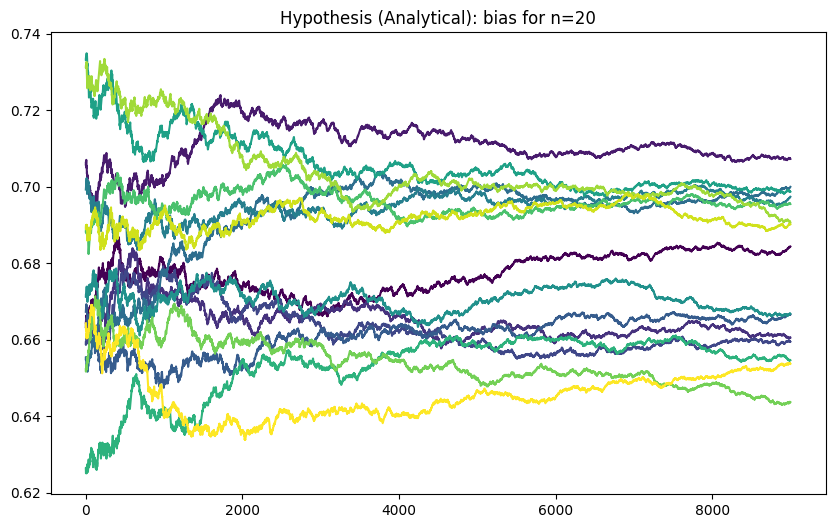

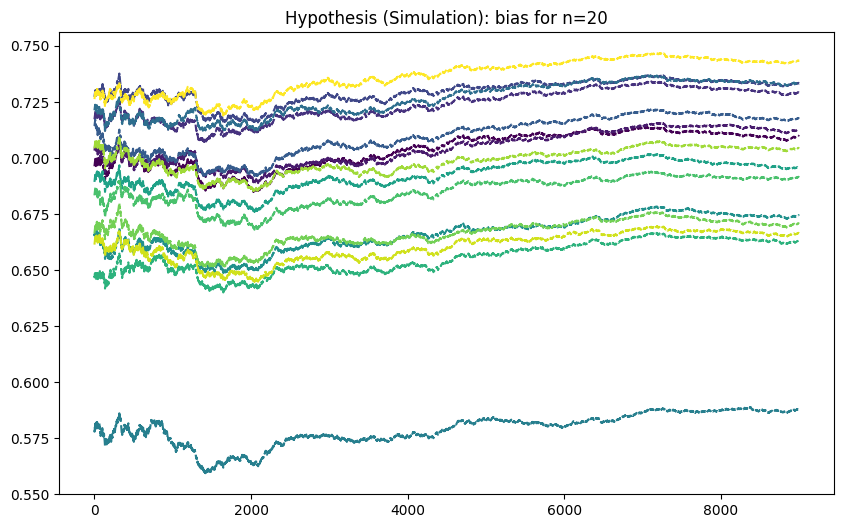

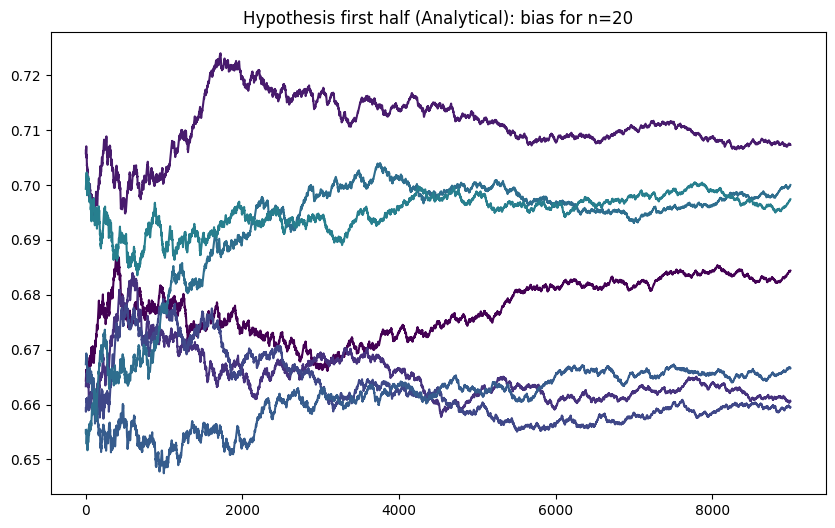

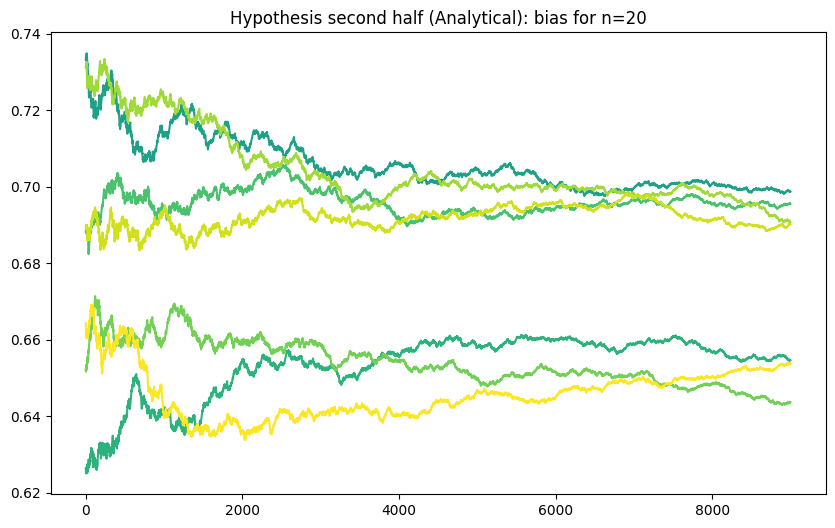

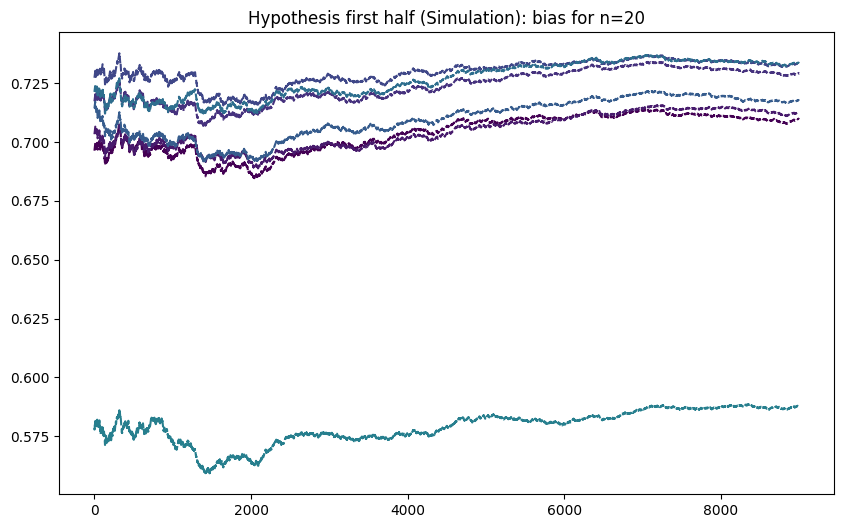

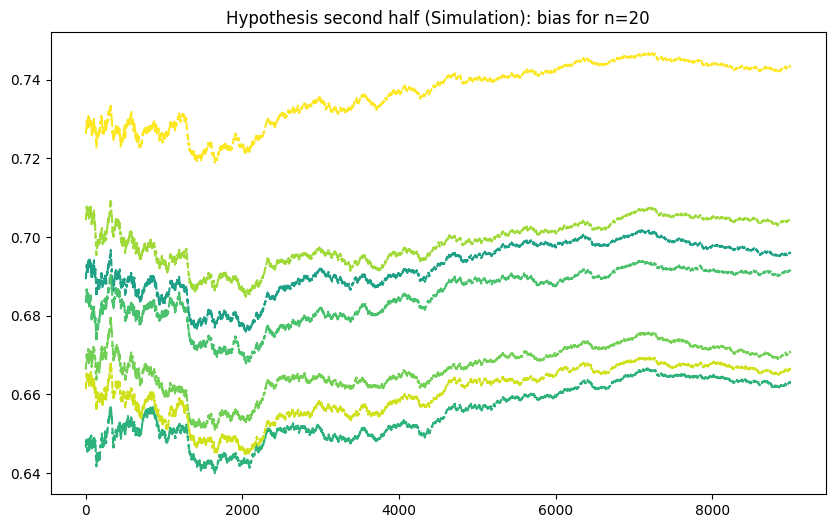

In [14]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)


# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()